# 1) Sample the interesting galaxies

# Overview
1) The "What"
2) Very small intermezzo on hydrosimulations
3) Loose structure of the code
4) The "how" - tutorial of the code

# The "What"
We want to study gravitational lenses obtained from particles of hydrosimulated galaxies- even more precisely, we want 

1) find lenses
2) compute the $\alpha$ map
3) study their density

While our project will differs in many aspects, these 3 core point should more or less be in common (except some possible different parametric requirement, e.g. the type of lenses).

# Very small intermezzo on hydrosimulations
You probably know as well as me, if not better, what an hydrodynamical simulation (henceforth hydrosim) is. However, just to be sure we all on the same page, I will recap here some very basic but necessary informations.
Hydrosims are composed of particles, divided in 4 classes:
1) **dark matter**
2) **gas**
3) **stars**
4) **black holes**


They mainly interact gravitationally, but being hydro (and not n-body) simulations, they also have peculiar and individual properties: star-formation, feedbacks, accretion etc. For what concerns lensing, however, we luckily can ignore all this and just treat them as massive particles for our lenses. 

Furthermore, the simulations evolve in time (thus in redshifts z), and its properties are then stored at given **snapshots (snap**) in time. Thus **z $\leftrightarrow$ snap**.

In each of these, the galaxy catalogues have been compiled (luckily!), thus finding the formed galaxies and linking the particle to a given galaxy, which in turn is charaterised by Mass and its redshift, properties we can select for.

# How

<figure>
<img src="tutorial_images/how.png" style="width:100%">
<figcaption align = "center"> 
Outline of pipeline aim
</figcaption>
</figure>


# Loose structure of the code
<figure>
<img src="tutorial_images/pipeline_structure.png" style="width:100%">
<figcaption align = "center"> 
Outline of pipeline code structure
</figcaption>
</figure>

# Tutorial

First we import some generally useful functions and names:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from python_tools.tools import mkdir
from python_tools.get_res import load_whatever

verbose = True

In [2]:
from pathlib import Path
# Locate the path for the particle data 
part_data_path =  Path("/pbs/home/g/gqueirolo/EAGLE/data/")

# define some useful variables to find particles and galaxies
from fnct import tutorial_sim,galdir2sim,sim2galdir

gal_dir = sim2galdir(tutorial_sim,part_data_path=part_data_path) 

# useful functions to translate from z to snap and viceversa
from fnct import get_z,get_snap,get_z_snap

#eg
snap =20
z = get_z(snap)
print(z)
print(get_snap(z))
print(get_z_snap(z=z))
# note the snap is usually a string

0.87
20
(0.87, '20')


For this tutorial we won't download the whole EAGLE simulation suite, but we will play around with a single snap of the simulation "RefL0012N0188", which has a comoving box size of 12 cMpc and 188^3 DM particles (initially = n* of baryonic particles). 

It's one of the smallest box used for tests, I usually use = "RefL0025N0752".

Moreover, to avoid to have you create a EAGLE account only for this tutorial, I have pre-downloaded all required data.


Finding lenses is the easiest part, given a galaxy catalogue (which is the case for EAGLE and COLIBRE luckily). We define a range of redshifts and a minimum mass, and get a list of galaxies that are our lens candidates. 

In [3]:
from get_gal_indexes_tutorial import get_gals
# given that we are running a limited test, we only have access to 1 snapshot, 
# thus we limit our redshift search to that range
gal_cat = get_gals(sim=tutorial_sim, # name of the simulation to use 
         min_z="0.7",max_z="0.9",
         gal_dir = gal_dir, # where to store the results
         plot=False)


# We can then plot


Found previous pickled catalogue:
/pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/CatGal_minM1e12_minZ7e-1_maxZ9e-1.pkl


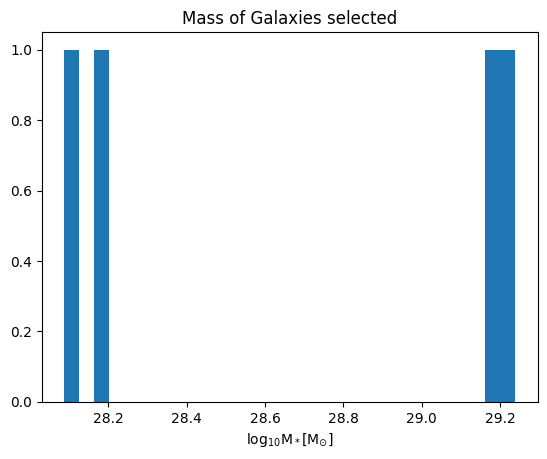

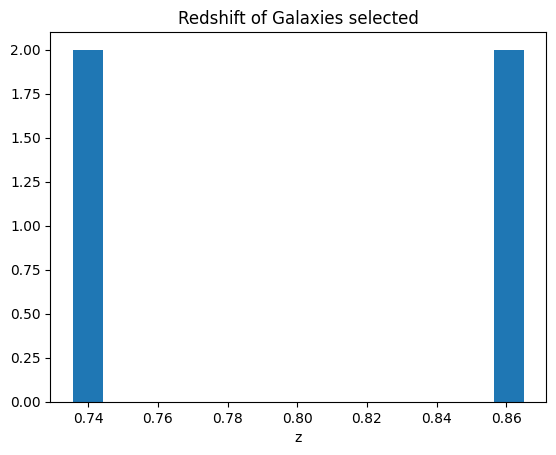

In [4]:
#waiting for gal_cat to work:
#gal_cat = load_whatever("/pbs/home/g/gqueirolo/EAGLE/data/RefL0025N0752/Gals/massive_gals.pkl")

#Plot of informative statistic data
logMass = np.log(gal_cat["M"])
str_logMass = r'log$_{10}$M${_*}$[M$_{\odot}$]'
zGal   = gal_cat["z"]
plt.hist(logMass,bins=30)
plt.title("Mass of Galaxies selected")
plt.xlabel(str_logMass)
plt.show()
plt.close()
plt.hist(zGal,bins=15)
plt.title("Redshift of Galaxies selected")
plt.xlabel(r'z')
plt.show()
plt.close()


In [5]:
gal_cat

{'Gn': array([2, 1, 1, 2], dtype=int32),
 'SGn': array([0, 0, 0, 0], dtype=int32),
 'z': array([0.7356296 , 0.7356296 , 0.86505054, 0.86505054]),
 'M': array([1.7252650e+12, 4.9908369e+12, 4.7049479e+12, 1.5786001e+12],
       dtype=float32),
 'CMx': array([ 2.0305352, 11.842675 , 11.810426 ,  2.0335684], dtype=float32),
 'CMy': array([10.609053,  4.189576,  4.159409, 10.743674], dtype=float32),
 'CMz': array([12.424929 ,  1.3904394,  1.3923634, 12.413954 ], dtype=float32),
 'query': 'SELECT         gal.GroupNumber as Gn,         gal.SubGroupNumber as SGn,         gal.Redshift as z,         gal.Mass as M,         gal.CentreOfMass_x as CMx,         gal.CentreOfMass_y as CMy,         gal.CentreOfMass_z as CMz      FROM         RefTuto_Subhalo as gal     WHERE         (gal.Redshift between 0.7 and 0.9) and         gal.Mass > 1e12     ORDER BY         gal.Redshift',
 'sim': 'RefL0012N0188'}

As seen, the gal_cat contains the "coordinates" of the interesting galaxies: Snapshot/redshift, Group number (Gn) and Sub-Group Number (SGn), as well as some further informations such as mass and coordinates of the center.

From this list, we can sample a candidate lens, and load its particles from the simulation dataset. We only care about their coordinates and masses, not their type.

In this tutorial, I will directly load a specific, preselected galaxy (to save time and limit memory usage). But in principle it selects a random one with "get_rnd_PG"


**-> NOTE due to time constraints, I had to use a galaxy from the standard simulation**


In [6]:
#from particle_galaxy import get_rnd_PG
from particle_galaxy import PartGal
Gn = 5
SGn = 0

part_gal = PartGal(Gn=Gn,
                    SGn=SGn,
                    snap=str(snap),
                    sim=tutorial_sim,
                    gal_dir=gal_dir)

File /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl is present
Loaded /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl:
Gal 5.0, at z=0.865/snap=20, with 
N=2.8E+06 part.
of 
tot Mass=2.4E+12 [M_sun]
 divided in N 
                Stars:2.3E+05
                Gas:8.2E+05
                DM:1.8E+06
                BH:2.4E+01
and Mass in 
                    Stars:3.7E+10 [M_sun]
                    Gas:2.0E+11 [M_sun]
                    DM:2.2E+12 [M_sun]
                    BH:1.0E+07 [M_sun]



The next steps, which are the core of the pipeline, are "under the hood" of the main class LensPart. All are run with the wrapper function "run()", but we can run them individually to understand the steps

Let us first create the lens class:

In [13]:
from generate_particle_lens import LensPart
# define the model for the lens particles 
# AS = arshinh, available is also point mass (PM)
from particle_lenses import default_kwlens_part_AS  as kwlens_part_AS

z_source_max = 4

# properties for the image construction 
# - more important later on for the simulation of realistic observations
from generate_particle_lens import kwargs_band_sim
pixel_num = 200 #number of pixels: Important! -> from this we define the resolution of the alpha map

# minimum accepted theta_E
from generate_particle_lens import min_thetaE # 0.3 #arcsec

# type of modelled source: 
# (can be modified - maybe could be implemented differently)
source_model_list         = ['SERSIC_ELLIPSE']

# where to store the lenses
sim_lens_path = Path("./sim_lens/") 
mkdir(sim_lens_path)

lens_part = LensPart(Galaxy=part_gal,
                  kwlens_part=kwlens_part_AS,
                  z_source_max=z_source_max, 
                  kwargs_band_sim=kwargs_band_sim,
                  pixel_num=pixel_num,
                  reload=True, # we will not re-compute everything here
                  savedir_sim="tuto_sim_lens", # name of the specific variation of lens algo
                  sim_lens_path = sim_lens_path)



In [18]:
lens_part.upload_prev() # reload previously computed instance

File sim_lens/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl is present
Loaded sim_lens/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl:
Gn5SGn0_Npix200_PartAS
File /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl is present
Loaded /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl:
Gal 5.0, at z=0.865/snap=20, with 
N=2.8E+06 part.
of 
tot Mass=2.4E+12 [M_sun]
 divided in N 
                Stars:2.3E+05
                Gas:8.2E+05
                DM:1.8E+06
                BH:2.4E+01
and Mass in 
                    Stars:3.7E+10 [M_sun]
                    Gas:2.0E+11 [M_sun]
                    DM:2.2E+12 [M_sun]
                    BH:1.0E+07 [M_sun]

Setting up lensing parameters...
We recenter around the densest point (MD) obtained with AMR
Info:  CM vs Densest 
CM: 0.0 arcsec 0.0 arcsec
Dns: -1.81 arcsec -3.35 arcsec
Dist: 3.8 arcsec


True

We can then project these particles into a 2D mass distribution and verify if their density is supercritical - even better, we can define a minimum $\theta_E$ such that our lensed images have a minimum of separation and can be resolved:

In [20]:
# all computations are done with the "run" call - here it loads prev. results
lens_part.run()
# we will still do the step "by hand"
from particle_galaxy import get_rnd_PG,Gal2kwMXYZ,LoadGal
from project_gal_AMR import Gal2kw_samples,ProjectionError
from project_gal_AMR import get_2Dkappa_map,prep_Gal_projpath,projection_main_AMR


# Read particles ONCE
# kwargs of Msun, XYZ in kpc (explicitely) centered around Centre of Mass (CM)
kw_parts   = Gal2kwMXYZ(lens_part.Gal) 
# Compute projection (uses Adaptive Mesh Refinement for density map estimation)
kwres_proj = projection_main_AMR(Gal=lens_part.Gal,
                                       kw_parts=kw_parts,
                                       z_source_max=lens_part.z_source_max,
                                       sample_z_source=lens_part.sample_z_source,
                                       min_thetaE=lens_part.min_thetaE,
                                       arcXkpc=lens_part.arcXkpc,
                                       verbose=verbose,
                                       save_res=False,
                                       reload=lens_part.reload)


File sim_lens/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl is present
Loaded sim_lens/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl:
Gn5SGn0_Npix200_PartAS
File /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl is present
Loaded /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_20/Gn5SGn0.pkl:
Gal 5.0, at z=0.865/snap=20, with 
N=2.8E+06 part.
of 
tot Mass=2.4E+12 [M_sun]
 divided in N 
                Stars:2.3E+05
                Gas:8.2E+05
                DM:1.8E+06
                BH:2.4E+01
and Mass in 
                    Stars:3.7E+10 [M_sun]
                    Gas:2.0E+11 [M_sun]
                    DM:2.2E+12 [M_sun]
                    BH:1.0E+07 [M_sun]

Setting up lensing parameters...
We recenter around the densest point (MD) obtained with AMR
Info:  CM vs Densest 
CM: 0.0 arcsec 0.0 arcsec
Dns: -1.81 arcsec -3.35 arcsec
Dist: 3.8 arcsec
Found and loaded projection from : /pbs/home/g/gqueirolo/EAGLE/data/RefTuto/Gals/snap_2

In [21]:
kwres_proj


{'proj_index': 0,
 'MD_value': <Quantity 4.26938404e+09 solMass / kpc2>,
 'MD_coords': <Quantity [-14.19180221, -26.32150055] kpc>,
 'z_source_min': np.float32(2.344573),
 'z_source': np.float64(2.3509926911637113),
 'thetaE': <Quantity 0.29927734 arcsec>}

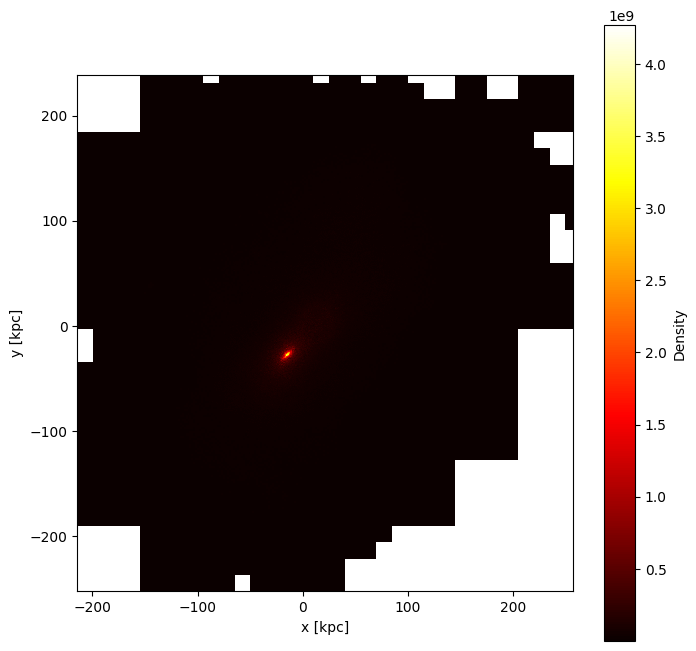

In [23]:
# for more details, check project_gal_AMR.py
from project_gal_AMR import project_kw_parts,dens_map_AMR,plot_amr_cells
#from AMR2D_PLL import plot_amr_cells
proj_index = kwres_proj["proj_index"]

# project particle into a 2D plane
kw_parts_proj = project_kw_parts(kw_parts=kw_parts,
                                 proj_index=proj_index)

# compute density map with AMR
kw_2Ddens = dens_map_AMR(kw_parts_proj=kw_parts_proj,
                         verbose=verbose)
fig,ax = plot_amr_cells(kw_2Ddens)
fig.show()

Locates the minimum z_source for the galaxy to be a lens

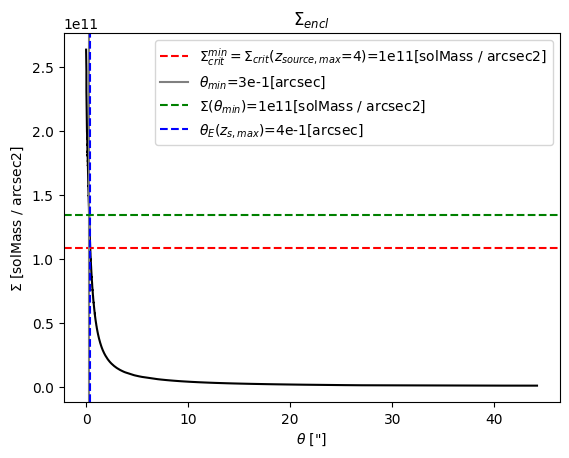

In [29]:
from project_gal_AMR import get_min_z_source
min_thetaE_kpc = lens_part.min_thetaE/lens_part.arcXkpc
z_source_max  =  lens_part.z_source_max
savenameSigmaEnc = "tutorial_images/Sigma_enc.png"
kw_z_min = get_min_z_source(Gal=lens_part.Gal,
                        min_thetaE_kpc=min_thetaE_kpc,
                        kw_2Ddens=kw_2Ddens,
                        z_source_max=z_source_max,
                        savenameSigmaEnc=savenameSigmaEnc,
                        verbose=verbose)



pseudo-code (it WONT work, but it explains what happens in the get_min_z_source):
```python
# compute density at minimum theta_E 
dens_at_thetamin = getDensAtRad(kw_2Ddens,min_thetaE_kpc)

# this is the density threshold
thresh_dens  = dens_at_thetamin

# convert it into a ratio of angular diameter distances Ds / Dds
thresh_DsDds = thresh_dens*4*np.pi*const.G*cosmo.angular_diameter_distance(z_lens)/(const.c**2) 

# this is the minimum Ds/Dds (ie Ds/Dds with maximum z_source)
min_DsDds = angular_diameter_distance(z_source_max)/angular_diameter_distance_z1z2(z_lens,z_source_max) 

# since DsDds is a very smooth function, we just need to find if and where these meet
z_source_range = np.linspace(z_lens+0.1,z_source_max,100) 
DsDds = np.array([angular_diameter_distance(z_s)./angular_diameter_distance_z1z2(z_lens,z_s)  for z_s in z_source_range])

# Note: successful test means that the threshold density = Sigmacrit given z_source =z_source_min
minimise     = np.abs(DsDds-thresh_DsDds) 
z_source_min = z_source_range[np.argmin(minimise)]
```



    
<figure>
<img src="tutorial_images/Sig_enc.png" style="width:100%">
<figcaption align = "center"> 
The black curve is the enclosed surface density $\Sigma_{encl}$ within an aperture $\theta$

$\Sigma_{crit}^{min}=\Sigma_{crit}(z_{source\, max}=4)$ is the minimum critical density allowed for the galaxy to be considered a lens, i.e. the critical density if the source is at the maximum allowed redshift  $z_{source\, max}$ (by default  $z_{source\, max}=$4)

$\theta_{min}$ is the minum allowed $\theta_E$

$\Sigma(\theta_{min})$ is the surface density at $\theta_{min}$ for this galaxy

$\theta_E(z_{s,max})$ is the Einstein radius of this lens if the source is located at the maximum allowed redshift $z_{source\, max}$.


$\Sigma_{crit}$ is the critical density given the sampled source redshift

$\theta_E$ is the resulting Einstein radius for this lens.
</figcaption>
</figure>
Note that for this we have to define a range of source redshift $z_{\text{source}}$, notably the maximum allowed $z_{\text{source max}}$, since the min is given by the lens redshift. 

To be even more picky, we defined a minimum Einstein radius $\theta_{min}$, such that the lensed images are separated by a minimum distance/angle, which is then compatible with realistic observational capabilities.

Note also that these computation of Einstein angle are approximate, since we are reducing the 2D density distribution into 1D, so it is appropriate only as a rough estimate of the quality of the lens.

Once we proved that it is a lens, we can compute the lensing properties of the galaxy, most importantly the $\alpha$ map.
First, some minor setup is then done in the run function. Most importantly, we define the resolution of the image by taking the 2x estimate $\theta_E$ as our aperture, centred around the coordinate of the maximum density (MD), and a number of pixel given as input (def.200).



In [ ]:
lens_part.